# Clustering de Imágenes con implementación de CPA

### Sobre Este Notebook

Este notebook comprende la segunda parte de nuestro proyecto, que consiste en mostrar un clúster de imágenes utilizando la librería t-sne. Para poder ejecutar las celdas que se incluyen en este notebook usted tendrá que descargar el archivo [products.zip](https://drive.google.com/file/d/1V534H_NHU2kWCo1zVDra-pXr2pQ40uth/view?usp=sharing) (favor acceder con correo institucional de la UVG) y descomprimirlo en el mismo folder donde almacene en este notebook.

In [1]:
import os
import time
import random
import numpy as np
import tensorflow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot
from matplotlib.pyplot import imshow
from PIL import Image

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Cargaremos una red neuronal previamente entrenada, VGG16, que viene incluida con Keras.

In [2]:
model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=True)

Para ingresar una imagen en la red, debe convertirse la imágen en un vector de características del tamaño correcto. Para ello, crearemos la función de abajo que tiene como propósito cargar una imagen de nuestro sistema de archivos y convertirla en un vector de entrada con las dimensiones esperadas por VGG16, es decir, una imagen en color de tamaño 224x224.

In [3]:
def cargar_imagen(path):
    imagen = image.load_img(path, target_size=model.input_shape[1:3])
    array_imagen = image.img_to_array(imagen)
    array_imagen = np.expand_dims(array_imagen, axis=0)
    array_imagen = preprocess_input(array_imagen)
    return imagen, array_imagen

Ahora, para nuestra función de extracción de features copiaremos el modelo, pero eliminaremos la última capa (la capa de clasificación), de modo que la capa final de la nueva red, llamada `extraer_features` sea la segunda capa completamente conectada de 4096 neuronas, "fc2 (Dense)".

In [4]:
extraer_features = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

Abriremos la carpeta que usted descargó y añadió acá (products). La función de abajo recorrerá de forma recursiva la carpeta especificada por `path_de_imagen` buscando imágenes de las extensiones dentro de` extensiones_imagenes` y luego limitándolas a un subconjunto aleatorio de imágenes máximas de `maximo_imagenes`. Usted puede variar estos parámetros pero debe tomar en cuenta que solo utilizamos 1000 imágenes en el folder que usted descargó de Google Drive.

In [5]:
path_de_imagen = 'products'
extensiones_imagenes = ['.jpg', '.png', '.jpeg']
maximo_imagenes = 10000

imagenes = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path_de_imagen) for f in filenames if os.path.splitext(f)[1].lower() in extensiones_imagenes]
if maximo_imagenes < len(imagenes):
    imagenes = [imagenes[i] for i in sorted(random.sample(range(len(imagenes)), maximo_imagenes))]

print("Se analizarán %d imagenes" % len(imagenes))

Se analizarán 10000 imagenes


A continuación,iteraremos sobre nuestro array de imágenes y abriremos cada imagen, extraeremos su vector de características y lo agregaremos a una lista llamada "features" que contendrá nuestras features para cada imagen.

In [6]:
timer1 = time.perf_counter()
features = []
for i, path_de_imagen in enumerate(imagenes):
    if i % 100 == 0:
        timer2 = time.perf_counter()
        elap = timer2-timer1;
        print("Analizando imagen %d / %d. en un tiempo de: %4.4f seconds." % (i, len(imagenes),elap))
        timer1 = time.perf_counter()
    imagen, array_imagen = cargar_imagen(path_de_imagen);
    feature = extraer_features.predict(array_imagen)[0]
    features.append(feature)

print('Se extrajeron las features para %d imagenes' % len(imagenes))

Analizando imagen 0 / 10000. en un tiempo de: 0.0002 seconds.
Analizando imagen 100 / 10000. en un tiempo de: 39.6809 seconds.
Analizando imagen 200 / 10000. en un tiempo de: 33.5015 seconds.
Analizando imagen 300 / 10000. en un tiempo de: 33.6241 seconds.
Analizando imagen 400 / 10000. en un tiempo de: 33.6111 seconds.
Analizando imagen 500 / 10000. en un tiempo de: 33.8961 seconds.
Analizando imagen 600 / 10000. en un tiempo de: 33.5848 seconds.
Analizando imagen 700 / 10000. en un tiempo de: 33.7874 seconds.
Analizando imagen 800 / 10000. en un tiempo de: 34.1859 seconds.
Analizando imagen 900 / 10000. en un tiempo de: 34.0745 seconds.
Analizando imagen 1000 / 10000. en un tiempo de: 33.4420 seconds.
Analizando imagen 1100 / 10000. en un tiempo de: 33.6804 seconds.
Analizando imagen 1200 / 10000. en un tiempo de: 34.0887 seconds.
Analizando imagen 1300 / 10000. en un tiempo de: 33.5307 seconds.
Analizando imagen 1400 / 10000. en un tiempo de: 33.7362 seconds.
Analizando imagen 1500 

Utilizamos PCA para reducir el monto de redundancia de nuestras features (duplicados y features con una correlación alta) y además para reducir la cantidad de memoria que el procesamiento de cada feature consume.

In [7]:
features = np.array(features)
pca = PCA(n_components=30)
pca.fit(features)
pca_features = pca.transform(features)

Prosegimos a delimitar el número de imágenes que mostraremos en la gráfica a través de la variable `imagenes_a_graficar`. Este parámetro es variable pero recuerde que el folder que descargó solo tiene 1000 imágenes. Si usted escoge un número menor al número de imágenes totales se randomizarán las imágenes seleccionadas para asegurarnos de no tomar solo la primera parte de todas las muestras y que esto ocasione resultados inconclusos.

In [8]:
imagenes_a_graficar = 10000

if len(imagenes) > imagenes_a_graficar:
    sort_order = sorted(random.sample(range(len(imagenes)), imagenes_a_graficar))
    imagenes = [imagenes[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

Creamos el objeto TSNE pasándole el array con las features

In [9]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 10.170011
[t-SNE] Computed conditional probabilities in 0.556s
[t-SNE] Iteration 50: error = 96.6411133, gradient norm = 0.0000089 (50 iterations in 9.339s)
[t-SNE] I

Extraemos coordenadas, máximos y mínimos y finalmente graficamos con la librería matplotlib

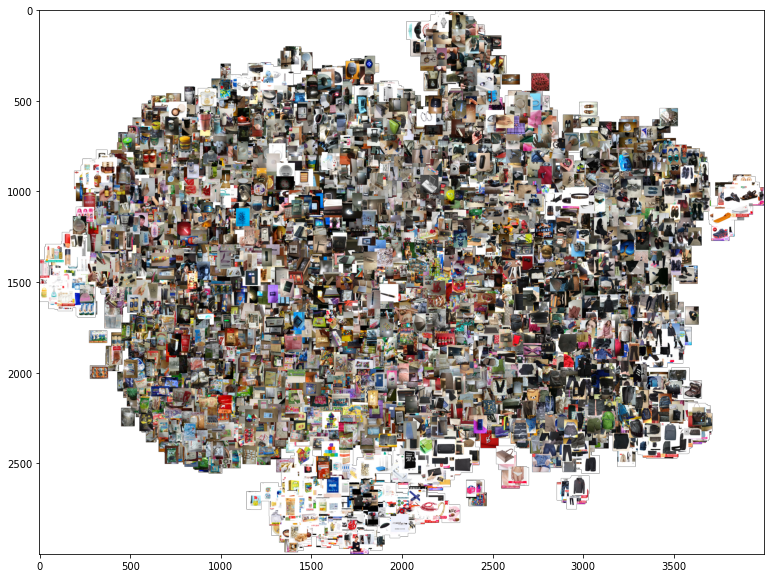

In [10]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

imagen_cluster = Image.new('RGBA', (4000, 3000))
for imagen, x, y in zip(imagenes, tx, ty):
    tile = Image.open(imagen)
    rs = max(1, tile.width/100, tile.height/100)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    imagen_cluster.paste(tile, (int((4000-100)*x), int((3000-100)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (14,10))
imshow(imagen_cluster)

La siguiente celda guarda la imagen en el mismo folder en el que se encuentra este notebook.

In [11]:
imagen_cluster.save("cluster.png")